# Data Split

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import random
import matplotlib.pyplot as plt
import numpy as np
from torch import optim
from torch.optim import lr_scheduler
import torchvision.models as models

torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')

# ----------------------------------------------------------------------------------------------
# Augmentation
# Define data augmentation transforms
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),  # Randomly rotate the image up to 30 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Adjust color
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random affine transformation
    transforms.RandomPerspective(),  # Random perspective transformation
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random resized crop
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    # transforms.Normalize(mean=[0.485], std=[0.229]) # gray scale, channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image to RGB
])

dataset = ImageFolder(root='/local/data1/honzh073/centralized_learning/data/8bit_dataset_patient', transform=transform)

# ----------------------------------------------------------------------------------------------
# Random seed
seed = 123
random.seed(seed)
torch.manual_seed(seed)

# Split dataset into 80% train, 20% test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(seed))

# DataLoader for training and testing
batch_size = 64

# Move train_loader and test_loader to GPU
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

# ----------------------------------------------------------------------------------------------
# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available!")
    device = torch.device("cuda:0") # we have GPU 0, 1
else:
    print("CUDA is not available.")
    device = torch.device("cpu")
# ----------------------------------------------------------------------------------------------
print('done!')


CUDA is available!
done!


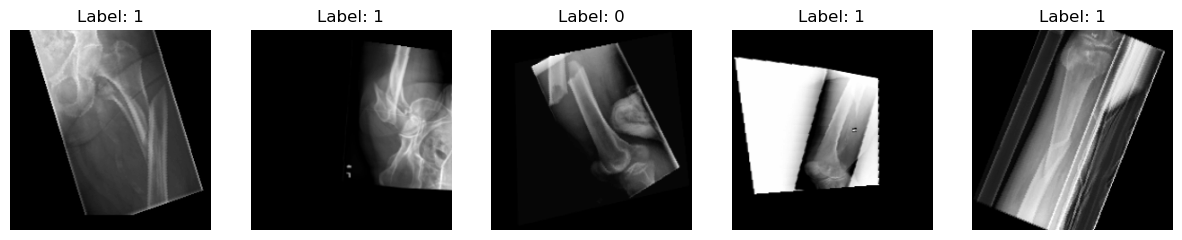

In [5]:
# ---------------------------------------------------------------------------------
# Get some random indices from the training dataset
random_indices = np.random.choice(len(train_dataset), 5, replace=False)

# Plot images (transformed)
plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_indices):
    image, label = train_dataset[idx]
    plt.subplot(1, 5, i + 1)
    plt.title(f"Label: {label}")
    # plt.imshow(image[0])  # 3-channel (RGB)
    plt.imshow(image[0], cmap='gray')  #single-channel (grayscale)
    plt.axis('off')
plt.show()


# Calculate Class Weights

In [6]:
# ---------------------------------------------------------------------------------
# aff and nff numbers in training dataset
train_aff_count = sum(1 for _, label in train_dataset if label == 0)  # 0 AFF
train_nff_count = sum(1 for _, label in train_dataset if label == 1)  # 1 NFF

# aff and nff numbers in test dataset
test_aff_count = sum(1 for _, label in test_dataset if label == 0)
test_nff_count = sum(1 for _, label in test_dataset if label == 1)

print(f"train aff number: {train_aff_count}")
print(f"train nff number: {train_nff_count}")
print(f"test aff number: {test_aff_count}")
print(f"test nff number: {test_nff_count}")

# ---------------------------------------------------------------------------------
# Calculate class weights
n_aff_train = train_aff_count
n_nff_train = train_nff_count

class_weight_aff = 1 / (2 * (n_aff_train / (n_aff_train + n_nff_train)))
class_weight_nff = 1 / (2 * (n_nff_train / (n_aff_train + n_nff_train)))

print(f"Class Weight for AFF (0): {class_weight_aff:.4f}")
print(f"Class Weight for NFF (1): {class_weight_nff:.4f}")


train aff number: 689
train nff number: 2784
test aff number: 179
test nff number: 690
Class Weight for AFF (0): 2.5203
Class Weight for NFF (1): 0.6237


In [ ]:
# class_weight_aff = 2.5203
# class_weight_nff = 0.6237

# Resnet152 5-fold

CUDA is available!
Fold 1/5
Epoch 1/25, Train Loss: 0.6018, Test Loss: 0.6219, Train Acc: 61.76%, Test Acc: 76.29%
Epoch 2/25, Train Loss: 0.5806, Test Loss: 0.5173, Train Acc: 76.79%, Test Acc: 80.78%
Epoch 3/25, Train Loss: 0.5592, Test Loss: 0.3755, Train Acc: 79.99%, Test Acc: 83.89%
Epoch 4/25, Train Loss: 0.9381, Test Loss: 0.6170, Train Acc: 80.19%, Test Acc: 72.84%
Epoch 5/25, Train Loss: 0.6288, Test Loss: 0.4518, Train Acc: 79.67%, Test Acc: 82.05%
Epoch 6/25, Train Loss: 0.7901, Test Loss: 0.4163, Train Acc: 81.72%, Test Acc: 84.81%
Epoch 7/25, Train Loss: 0.5617, Test Loss: 0.4331, Train Acc: 81.83%, Test Acc: 77.91%
Epoch 8/25, Train Loss: 0.3171, Test Loss: 0.3435, Train Acc: 85.66%, Test Acc: 86.54%
Epoch 9/25, Train Loss: 0.2970, Test Loss: 0.3984, Train Acc: 83.79%, Test Acc: 83.77%
Epoch 10/25, Train Loss: 0.3967, Test Loss: 0.4269, Train Acc: 86.50%, Test Acc: 84.81%
Epoch 11/25, Train Loss: 0.3302, Test Loss: 0.3350, Train Acc: 84.57%, Test Acc: 86.77%
Epoch 12/25, 

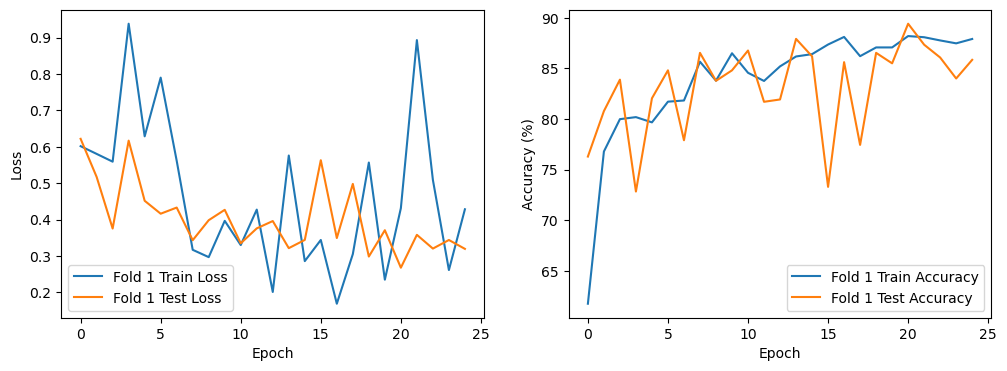

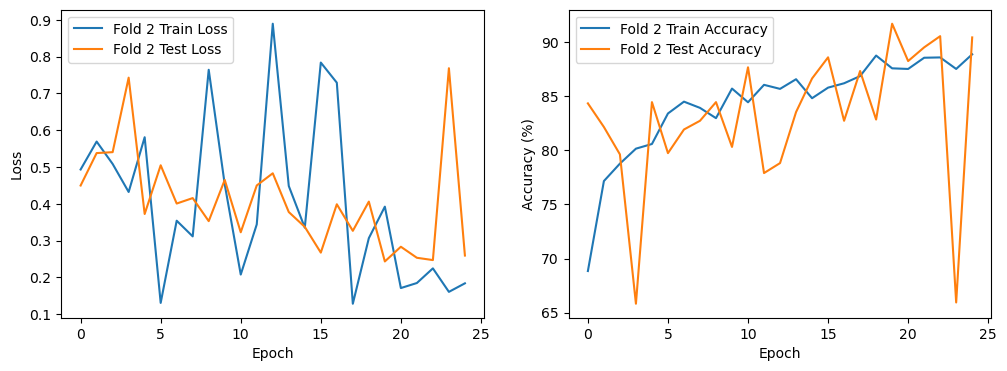

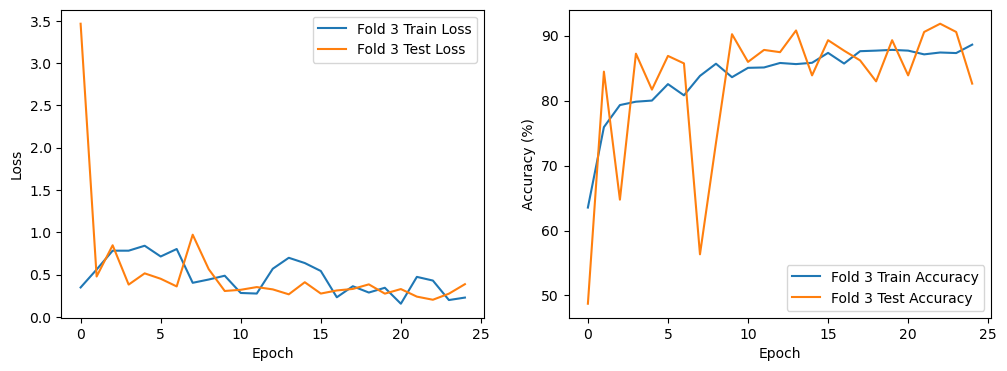

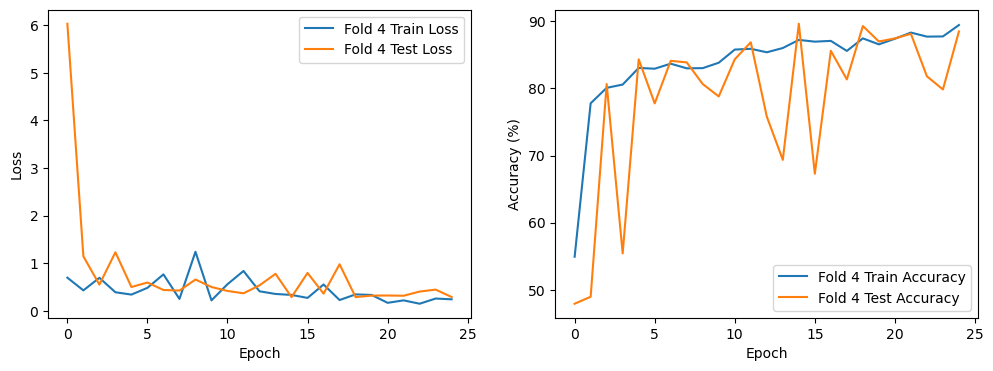

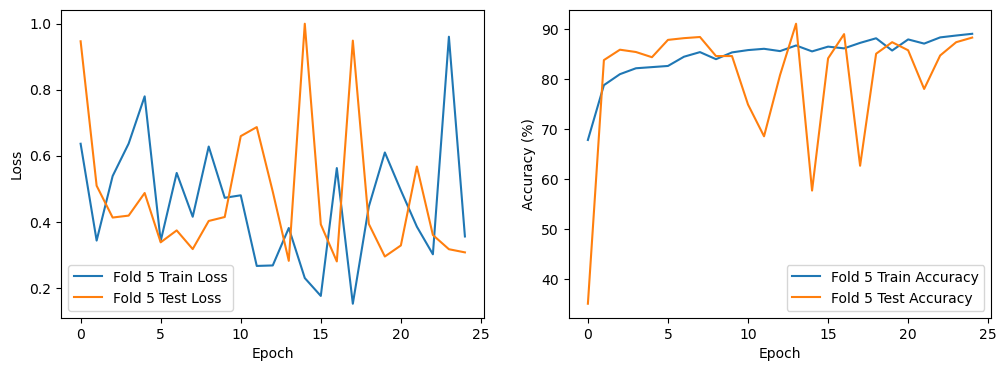

In [7]:
from sklearn.model_selection import KFold  # Import KFold for cross-validation
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Subset
import random
import matplotlib.pyplot as plt  # Import Matplotlib for plotting
from torchvision.models import resnet152, ResNet152_Weights

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available!")
    device = torch.device("cuda:0")
else:
    print("CUDA is not available.")
    device = torch.device("cpu")

# Move class weights to the selected device
class_weights = [class_weight_aff, class_weight_nff]
class_weights = torch.Tensor(class_weights).to(device)

# Define the number of folds for cross-validation
num_folds = 5

# Create a KFold object to split the dataset
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize lists to store accuracy and loss values for each fold
fold_train_accuracies = []
fold_test_accuracies = []
fold_train_losses = []
fold_test_losses = []

for fold, (train_indices, test_indices) in enumerate(kf.split(dataset)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Split the dataset into train and test sets for this fold
    train_dataset = Subset(dataset, train_indices)
    test_dataset = Subset(dataset, test_indices)

    # Create data loaders for train and test sets
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    # ResNet152
    model = models.resnet152(weights=ResNet152_Weights.DEFAULT)

    # Update the output layer
    model.fc = nn.Linear(2048, 2)  # output layer classes number = dataset classes number
    model = model.to(device)

    # Loss function
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    criterion = criterion.to(device)

    # optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Lists to store loss and accuracy values
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    num_epochs = 25
    for epoch in range(num_epochs):
        model.train()
        correct_train = 0  # Correct predictions during training
        total_train = 0    # Total examples during training

        for images, labels in train_loader:
            # Move images and labels to the selected device
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate training accuracy within this batch
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train  # Calculate training accuracy

        model.eval()
        correct_test = 0   # Correct predictions during testing
        total_test = 0     # Total examples during testing
        test_loss = 0      # Variable to store test loss

        with torch.no_grad():
            for images, labels in test_loader:
                # Move images and labels to the selected device
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
                test_loss += criterion(outputs, labels).item()  # Accumulate test loss

        # Calculate test accuracy
        test_accuracy = 100 * correct_test / total_test

        # Calculate average test loss
        test_loss /= len(test_loader)

        # Record training and test loss and accuracy
        train_losses.append(loss.item())
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%")

    # Append the accuracy and loss values for this fold to the respective lists
    fold_train_accuracies.append(train_accuracies)
    fold_test_accuracies.append(test_accuracies)
    fold_train_losses.append(train_losses)
    fold_test_losses.append(test_losses)

# Plot loss and accuracy for each fold
for fold in range(num_folds):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(fold_train_losses[fold], label=f'Fold {fold + 1} Train Loss')
    plt.plot(fold_test_losses[fold], label=f'Fold {fold + 1} Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(fold_train_accuracies[fold], label=f'Fold {fold + 1} Train Accuracy')
    plt.plot(fold_test_accuracies[fold], label=f'Fold {fold + 1} Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

plt.show()


In [8]:
# Save the trained VGG model
# torch.save(model.state_dict(), 'patient_5fold_resnet152.pth')


# Image Classification Demo

# 5-fold validation VGG

In [ ]:
from sklearn.model_selection import KFold  # Import KFold for cross-validation
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Subset
import random
import matplotlib.pyplot as plt  # Import Matplotlib for plotting
from torchvision.models import vgg19, VGG19_Weights

# Define the number of folds for cross-validation
num_folds = 5

# Create a KFold object to split the dataset
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize lists to store accuracy and loss values for each fold
fold_train_accuracies = []
fold_test_accuracies = []
fold_train_losses = []
fold_test_losses = []

for fold, (train_indices, test_indices) in enumerate(kf.split(dataset)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Split the dataset into train and test sets for this fold
    train_dataset = Subset(dataset, train_indices)
    test_dataset = Subset(dataset, test_indices)

    # Create data loaders for train and test sets
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    # VGG19
    model = models.vgg19(weights=VGG19_Weights.DEFAULT)

    # Modify the classifier part for your specific number of classes
    model.classifier[6] = nn.Linear(4096, 2)  # output layer classes number = dataset classes number
    model = model.to(device)

    # Loss function
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    criterion = criterion.to(device)

    # optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Lists to store loss and accuracy values
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    num_epochs = 25
    for epoch in range(num_epochs):
        model.train()
        correct_train = 0  # Correct predictions during training
        total_train = 0    # Total examples during training

        for images, labels in train_loader:
            # Move images and labels to the selected device
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate training accuracy within this batch
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train  # Calculate training accuracy

        model.eval()
        correct_test = 0   # Correct predictions during testing
        total_test = 0     # Total examples during testing
        test_loss = 0      # Variable to store test loss

        with torch.no_grad():
            for images, labels in test_loader:
                # Move images and labels to the selected device
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
                test_loss += criterion(outputs, labels).item()  # Accumulate test loss

        # Calculate test accuracy
        test_accuracy = 100 * correct_test / total_test

        # Calculate average test loss
        test_loss /= len(test_loader)

        # Record training and test loss and accuracy
        train_losses.append(loss.item())
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%")

    # Append the accuracy and loss values for this fold to the respective lists
    fold_train_accuracies.append(train_accuracies)
    fold_test_accuracies.append(test_accuracies)
    fold_train_losses.append(train_losses)
    fold_test_losses.append(test_losses)

# Plot loss and accuracy for each fold
for fold in range(num_folds):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(fold_train_losses[fold], label=f'Fold {fold + 1} Train Loss')
    plt.plot(fold_test_losses[fold], label=f'Fold {fold + 1} Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(fold_train_accuracies[fold], label=f'Fold {fold + 1} Train Accuracy')
    plt.plot(fold_test_accuracies[fold], label=f'Fold {fold + 1} Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

plt.show()


In [ ]:
# Save the trained VGG model
# torch.save(model.state_dict(), '5fold_vgg19_xray_classifier.pth')
